In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [2]:
from skimage import data, color, feature
import skimage.data

image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize=True)

In [3]:
image.shape

(300, 451)

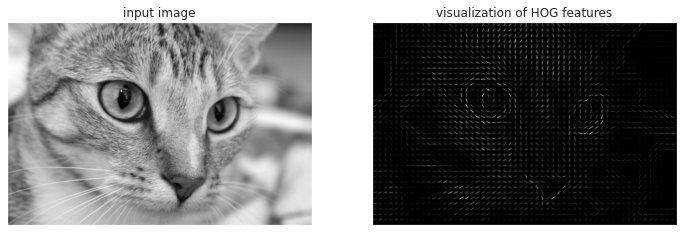

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis, cmap='gray')
ax[1].set_title('visualization of HOG features');

In [5]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

In [6]:
from skimage import data, transform

imgs_to_use = ['text', 'coins', 'moon', 'page', 'clock', 'immunohistochemistry', 'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)()) for name in imgs_to_use]

In [7]:
images = np.asarray(images)

In [8]:
positive_patches[0].shape

(62, 47)

In [9]:
extracted_patch_size = tuple((1 * np.array(positive_patches[0].shape)).astype(int))
extracted_patch_size

(62, 47)

In [10]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size) for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale) for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(27000, 62, 47)

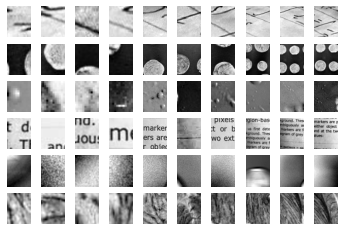

In [11]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[300*i], cmap='gray')
    axi.axis('off')

In [13]:
from itertools import chain
X_train = np.array([feature.hog(im) for im in chain(positive_patches, negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [14]:
X_train.shape

(40233, 1215)

In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train)

array([0.93550391, 0.9731577 , 0.97054803, 0.97278151, 0.97166294])

In [16]:
from sklearn import svm
svm_model = svm.SVC(kernel='linear', C=10000)
svm_model.fit(X_train, y_train)

SVC(C=10000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [17]:
svm_model.score(X_train, y_train)

1.0

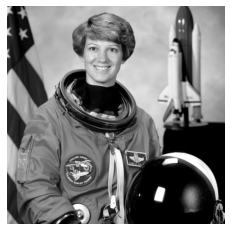

In [19]:
from skimage import io
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
plt.imshow(test_image, cmap='gray')
plt.axis('off');

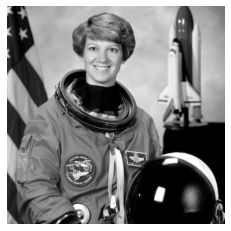

In [21]:
test_image = skimage.transform.rescale(test_image, 0.75)
plt.imshow(test_image, cmap='gray')
plt.axis('off');

In [22]:
test_image.shape

(384, 384)

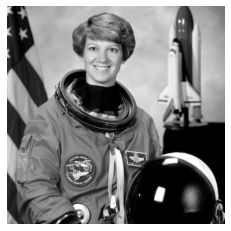

In [23]:
plt.imshow(test_image, cmap='gray')
plt.axis('off');

In [24]:
def sliding_window(img, patch_size=positive_patches[0].shape, istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(25921, 1215)

In [25]:
labels = svm_model.predict(patches_hog)
labels.sum()

923.0

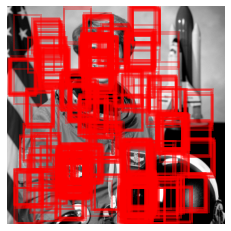

In [47]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)
rects = []
for i, j in indices[labels == 1]:
    rect = [j, i, (j+Nj), (i+Ni)]
    rects.append(rect)
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red', alpha=0.3, lw=2, facecolor='none'))

In [48]:
from imutils.object_detection import non_max_suppression
pick = non_max_suppression(np.asarray(rects), probs=None, overlapThresh=0.05)

In [49]:
pick

array([[278, 320, 325, 382],
       [204, 320, 251, 382],
       [ 14, 320,  61, 382],
       [ 86, 316, 133, 378],
       [138, 308, 185, 370],
       [ 42, 264,  89, 326],
       [ 92, 256, 139, 318],
       [232, 254, 279, 316],
       [320, 240, 367, 302],
       [152, 214, 199, 276],
       [268, 200, 315, 262],
       [ 44, 176,  91, 238],
       [190, 158, 237, 220],
       [316, 156, 363, 218],
       [130, 156, 177, 218],
       [246, 142, 293, 204],
       [ 12, 110,  59, 172],
       [208,  94, 255, 156],
       [136,  90, 183, 152],
       [ 58,  84, 105, 146],
       [254,  48, 301, 110],
       [168,  34, 215,  96],
       [ 46,  24,  93,  86],
       [100,   4, 147,  66],
       [216,   0, 263,  62]])

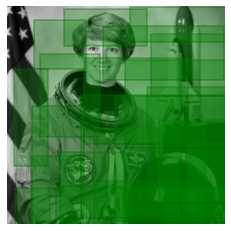

In [50]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)
rects = []
for j, i, k, l in pick:
    ax.add_patch(plt.Rectangle((j, i), k, l, edgecolor='darkgreen', alpha=0.3, lw=2, facecolor='green'))